In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import numpy.random as rnd

In [2]:
import tensorflow
import gpflow
import sys
import time

/Users/widrow/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/widrow/anaconda/lib/python3.6/site-packages/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Identity, NoneType, Kernel, InducingPoints], [Gaussian, Linear, NoneType, Sum, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


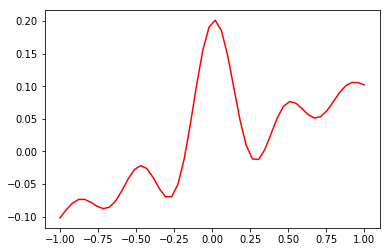

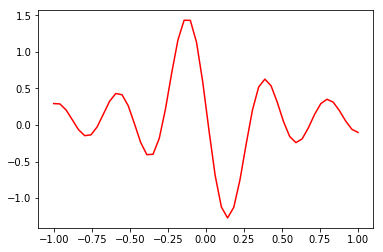

In [3]:
def f(amp,slope,k,xo,X):
    return slope*X + amp*np.sin(k*(X-xo))/(X-xo)/k

def fR(kR,xR,X):
    return np.sin(kR*(X-xR))

def df(amp,slope,k,xo,X):
    return slope + amp*(np.cos(k*(X-xo))/(X-xo) - np.sin(k*(X-xo))/k/(X-xo)**2)


h = 0.3
amp = 0.2
k = 2.*np.pi/0.4
slope = 0.1
xo = 0.01
zmax = 1.
zmin = -zmax

fig,ax = plt.subplots()
ax.plot(np.linspace(zmin,zmax),f(amp,slope,k,xo,np.linspace(zmin,zmax)),'r-')
plt.show()

fig,ax = plt.subplots()
ax.plot(np.linspace(zmin,zmax),df(amp,slope,k,xo,np.linspace(zmin,zmax)),'r-')
plt.show()

In [4]:
N = 10000
zsig = 0.2
print (h)
u = np.random.uniform(-1,1,N)
z = h*np.arctanh(u)
wbar = f(amp,slope,k,xo,z)
w = np.random.normal(wbar,zsig,N)

0.3


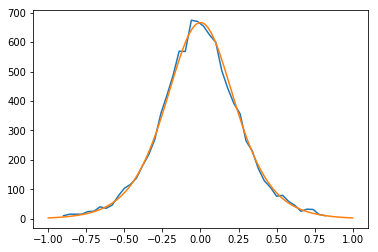

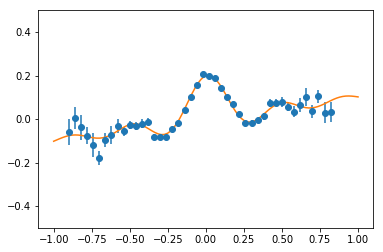

In [5]:
ngrid = 50
zrange = np.array([zmin,zmax])
dz = (zmax-zmin)/np.float(ngrid)
nz, ze = np.histogram(z,bins=ngrid,range=zrange)
indx = np.where(nz>10)
nz = nz[indx]
nzw, ze = np.histogram(z,bins=ngrid,range=zrange,weights=w)
nzw = nzw[indx]
wave = nzw/nz
nzw2, zw = np.histogram(z,bins=ngrid,range=zrange,weights=w*w)
nzw2 = nzw2[indx]/nz
sig = np.sqrt(nzw2 - wave**2)
nbin = nz.shape[0]
ew = sig/np.sqrt(nz)
zc = 0.5*(ze[:ngrid]+ze[1:])
zc = zc[indx]

Nf = 100
zf = np.linspace(zmin,zmax,Nf)
nz_exact = np.float(N)*dz/np.cosh(zf/h)**2/2/h
w_exact = f(amp,slope,k,xo,zf)

plt.figure()
plt.plot(zc,nz)
plt.plot(zf,nz_exact)
plt.show()

plt.figure()
plt.errorbar(zc,wave,yerr=ew,fmt='o')
plt.plot(zf,w_exact)
plt.ylim(-.5,.5)
plt.show()

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


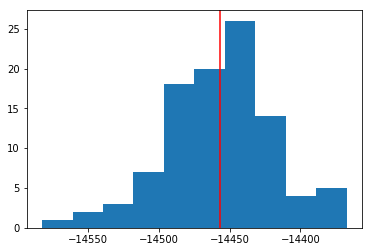

In [6]:
X = z[:,None]
Y = w[:,None]
D = 1

def init():
    kern = gpflow.kernels.RBF(D, 1)# + gpflow.kernels.White(D,1)
    Z = X[:ngrid, :].copy()
    m = gpflow.models.SVGP(X, Y, kern, gpflow.likelihoods.Gaussian(), Z, minibatch_size=len(X))
    return m

m = init()

ground_truth = m.compute_log_likelihood()
m.X.set_batch_size(100)
m.Y.set_batch_size(100)
evals = [m.compute_log_likelihood() for _ in range(100)]
plt.hist(evals)
plt.axvline(ground_truth,c='red')
plt.show()

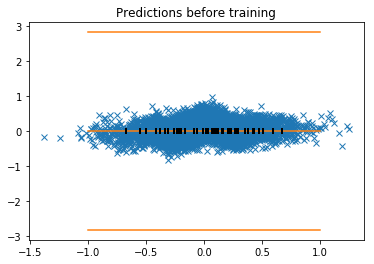

In [7]:
def plot():
    pX = np.linspace(-1, 1, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    plt.plot(X, Y, 'x')
    line, = plt.plot(pX, pY, lw=1.5)
    col = line.get_color()
    plt.plot(pX, pY+2*pYv**0.5, col, lw=1.5)
    plt.plot(pX, pY-2*pYv**0.5, col, lw=1.5)
    plt.plot(m.feature.Z.value, np.zeros(m.feature.Z.value.shape), 'k|', mew=2)

plot()
plt.title("Predictions before training")
plt.show()

In [8]:
st = time.time()
logt = []
logx = []
logf = []
def logger(x):
    if (logger.i % 10000) == 0:
        logx.append(x)
        logf.append(m._objective(x)[0])
        logt.append(time.time() - st)
    logger.i+=1
logger.i = 1

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


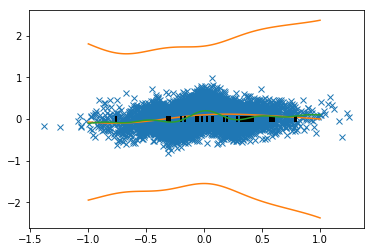

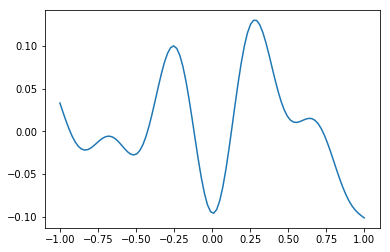

In [9]:
opt = gpflow.train.AdamOptimizer()
opt.minimize(m, maxiter=400)

plt.figure()
plot()
plt.plot(zf,w_exact)
Xstar = zf[:,None]
wp, wpvar = m.predict_f(Xstar)
plt.show()

plt.figure()
plt.plot(zf,wp[:,0]-w_exact)
plt.show()

In [10]:
import GPy
kern = GPy.kern.RBF(1)  + GPy.kern.White(1)

In [11]:
X = zc[:,None]
Y = wave[:,None]
error = ew[:,None]
mGP = GPy.models.GPHeteroscedasticRegression(X,Y,kern)
mGP['.*het_Gauss.variance'] = abs(error**2) #Set the noise parameters to the error in Y
mGP.het_Gauss.variance.fix() #We can fix the noise term, since we already know it
mGP.optimize_restarts(num_restarts=10)
#plt.errorbar(X,Y,yerr=np.array(mGP.likelihood.flattened_parameters).flatten(),fmt=None,ecolor='r',zorder=1)
#plt.plot(X,Y,'kx',mew=1.5)
#plt.show()

Optimization restart 1/10, f = -87.91965280538639
Optimization restart 2/10, f = -87.91966566715851
Optimization restart 3/10, f = -87.91966739163598
Optimization restart 4/10, f = -87.91966705475181
Optimization restart 5/10, f = -87.91966688094746
Optimization restart 6/10, f = -87.9196674065409
Optimization restart 7/10, f = -87.91965799267231
Optimization restart 8/10, f = -87.91965909320157
Optimization restart 9/10, f = -87.91966439141294
Optimization restart 10/10, f = -87.91966716956377


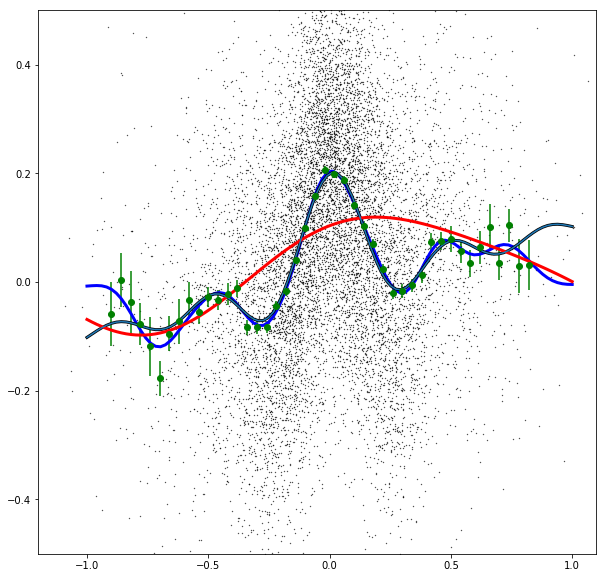

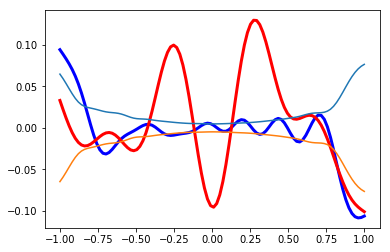

In [12]:
Xf = zf[:,None]
Yf, Yfvar = mGP.predict_noiseless(Xf)
sig = np.sqrt(Yfvar[:,0])
plt.figure(figsize=(10,10))
plt.plot(zf,Yf[:,0],c='blue',lw=3)
plt.plot(zf,w_exact,c='black',lw=3)
plt.plot(zf,wp[:,0],c='red',lw=3)
plt.scatter(z,w,s=0.1,c='black')
plt.errorbar(zc,wave,yerr=ew,fmt='o',c='green')
plt.plot(zf,w_exact)
plt.xlim(-1.2,1.1)
plt.ylim(-0.5,0.5)
plt.show()
plt.figure()
plt.plot(zf,Yf[:,0]-w_exact,c='blue',lw=3)
plt.plot(zf,wp[:,0]-w_exact,c='red',lw=3)
plt.plot(zf,sig)
plt.plot(zf,-sig)
plt.show()

In [14]:
N = 10000
Nind = 250
Nbatch = 1000
zsig = 0.2
u = np.random.uniform(-1,1,N)
z = h*np.arctanh(u)
wbar = f(amp,slope,k,xo,z)
w = np.random.normal(wbar,zsig,N)

kR = np.pi
Ro = 0.75
xR = .5
w2D = w*fR(kR,xR,z)
Rmin = 0.01
Rmax = 3.
umin = np.exp(-Rmin/Ro)
umax = np.exp(-Rmax/Ro)
R = -Ro*np.log(np.random.uniform(umax,umin,N))

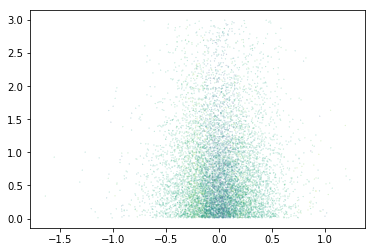

In [15]:
plt.scatter(z,R,s=0.01,c=w2D)
plt.show()

In [16]:
X = np.array((z,R)).transpose()
Y = w2D[:,None]
D = 2

def init():
    kern = gpflow.kernels.RBF(input_dim=D,ARD=True,lengthscales=(0.5,0.2))# + gpflow.kernels.White(D,1)
    Z = X[:Nind, :].copy()
    m2D = gpflow.models.SVGP(X, Y, kern, gpflow.likelihoods.Gaussian(), Z, minibatch_size=len(X))
    return m2D

m2D = init()

ground_truth = m2D.compute_log_likelihood()
m.X.set_batch_size(Nbatch)
m.Y.set_batch_size(Nbatch)

In [17]:
st = time.time()
logt = []
logx = []
logf = []
def logger(x):
    if (logger.i % 10) == 0:
        logx.append(x)
        logf.append(m2D._objective(x)[0])
        logt.append(time.time() - st)
    logger.i+=1
logger.i = 1

In [19]:
opt = gpflow.train.AdamOptimizer()
opt.minimize(m2D, maxiter=10)

In [ ]:
nR = 100
Rf = np.linspace(Rmin,Rmax,nR)
zm, Rm = np.meshgrid(zf,Rf,indexing='ij')
zg = zm.flatten()
Rg = Rm.flatten()
print (zm.shape)
Xstar = np.array((zg,Rg)).transpose()
w2Dmodel, w2Dvar = m2D.predict_f(Xstar)
w2Dmodel = w2Dmodel.reshape(Nf,nR)

wexact = f(amp,slope,k,xo,zm)*fR(kR,xR,Rm)
wmax = np.max(np.abs(wexact))

plt.figure()
plt.pcolormesh(zm,Rm,wexact,cmap='jet',vmin=-wmax,vmax=wmax)
plt.scatter(z,R,w2D)
plt.show()

plt.pcolormesh(zm,Rm,w2Dmodel,cmap='jet',vmin=-wmax,vmax=wmax)
plt.show()

wexact = f(amp,slope,k,xo,zm)*fR(kR,xR,Rm)